<a href="https://colab.research.google.com/github/fadheladlansyah/fruits-fresh-and-rotten/blob/master/fruit_rotten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Tensorboard init
%load_ext tensorboard
import datetime, os

import tensorflow as tf
import keras
import os

## ARANGE DATASET
import numpy as np
import pandas as pd
import random
import cv2
import json

import sys
import json
import glob
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
## Install Kaggle library
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

## 1) Upload kaggle API key file
from google.colab import files
uploaded = files.upload()

In [0]:
## 2) Auth with our Kaggle Account
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
## 3) Download Dataset
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

100% 3.57G/3.58G [01:10<00:00, 53.0MB/s]
100% 3.58G/3.58G [01:10<00:00, 54.4MB/s]


In [0]:
!unzip *.zip 

In [0]:
train_image_generator = ImageDataGenerator(
                          rescale=1./255,
                          rotation_range=45,
                          width_shift_range=.15,
                          height_shift_range=.15,
                          horizontal_flip=True
                        )
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size = 32
path = './dataset/dataset/train'
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=path,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 10901 images belonging to 6 classes.


In [0]:
validation_dir = './dataset/dataset/test'
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 2698 images belonging to 6 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

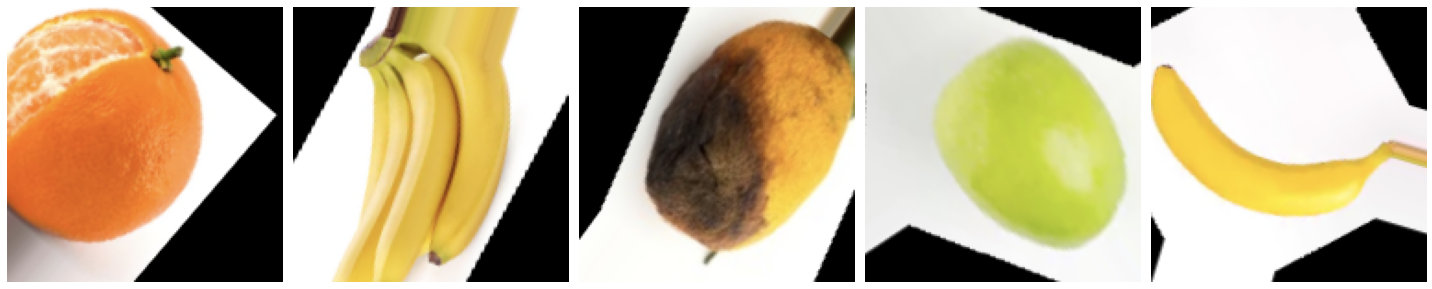

In [0]:
plotImages(sample_training_images[:5])

In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(6, activation='sigmoid')
])

In [0]:
model.compile(optimizer='adam',
             loss=keras.losses.categorical_crossentropy,
             metrics=['accuracy'])


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [0]:
epochs = 5
## Tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[tensorboard_callback]
)

Epoch 1/5
341/341 [==============================] - 102s 300ms/step - loss: 0.1673 - accuracy: 0.9365 - val_loss: 0.1813 - val_accuracy: 0.9340
Epoch 2/5
341/341 [==============================] - 102s 298ms/step - loss: 0.1554 - accuracy: 0.9416 - val_loss: 0.1491 - val_accuracy: 0.9426
Epoch 3/5
341/341 [==============================] - 101s 297ms/step - loss: 0.1504 - accuracy: 0.9450 - val_loss: 0.1518 - val_accuracy: 0.9396
Epoch 4/5
341/341 [==============================] - 102s 299ms/step - loss: 0.1292 - accuracy: 0.9501 - val_loss: 0.0858 - val_accuracy: 0.9663
Epoch 5/5
341/341 [==============================] - 101s 296ms/step - loss: 0.1299 - accuracy: 0.9515 - val_loss: 0.2071 - val_accuracy: 0.9214


In [0]:
## Open TENSORBOARD
%tensorboard --logdir logs

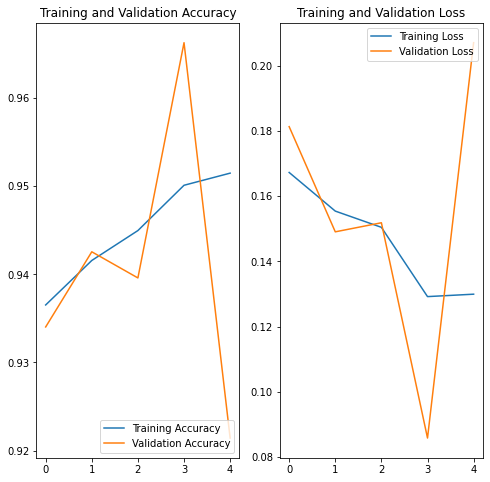

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model.save('fruits_rotten.h5') 

In [0]:
im_path = 'image_test/banana_f1.jpeg'
image_test = cv2.imread(im_path)

In [0]:
## Predict from image
from PIL import Image

img = Image.fromarray(image_test, 'RGB')
img = img.resize((150, 150))
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = img/255

In [0]:
prediction = model.predict(img)

In [0]:
prediction*100

array([[5.7133558e-11, 6.0449864e-08, 2.7670460e-13, 5.4674620e-09,
        2.0174173e-06, 1.8895979e-01]], dtype=float32)

In [0]:
## Visualize Filter (weight)

from matplotlib import pyplot

def visualize_weight_filter(k_layer=0, n_node=6):
  filters, biases = model.layers[k_layer].get_weights()
  # MinMaxScalling (0-1)
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)

  # plot first few filters
  n_filters, ix = n_node, 1
  for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
      # specify subplot and turn of axis
      ax = pyplot.subplot(n_filters, 3, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      pyplot.imshow(f[:, :, j], cmap='gray')
      ix += 1
  # show the figure
  pyplot.show()

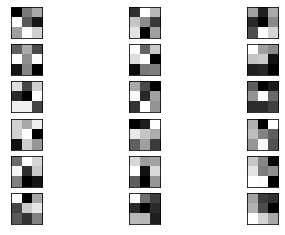

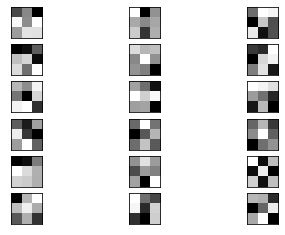

In [0]:
visualize_weight_filter(k_layer=0, n_node=6)
visualize_weight_filter(k_layer=3, n_node=6)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = './image_test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

Found 0 images belonging to 0 classes.


ValueError: ignored

In [0]:
filenames

[]

TypeError: ignored